In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
from torch import nn
from torchvision import models
import os

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)



In [4]:
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(x_lstm[:,-1,:]))


In [5]:
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize =  transforms.Normalize(mean=-1*np.divide(mean,std),std=np.divide([1,1,1],std))
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    return image

def predict(model,img,path = './'):
  fmap,logits = model(img.to('cpu'))
  weight_softmax = model.linear1.weight.detach().cpu().numpy()
  logits = sm(logits)
  _,prediction = torch.max(logits,1)
  confidence = logits[:,int(prediction.item())].item()*100
  idx = np.argmax(logits.detach().cpu().numpy())
  _, nc, h, w = fmap.shape
  out = np.dot(fmap[-1].detach().cpu().numpy().reshape((nc, h*w)).T,weight_softmax[idx,:].T)
  predict = out.reshape(h,w)
  predict = predict - np.min(predict)
  predict_img = predict / np.max(predict)
  predict_img = np.uint8(255*predict_img)
  out = cv2.resize(predict_img, (im_size,im_size))
  heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
  img = im_convert(img[:,-1,:,:,:])
  result = heatmap * 0.5 + img*0.8*255
  cv2.imwrite(r'E:\KLTN__Final\code\Predict\heatmap\heatmap.png',result)
  result1 = heatmap * 0.5 + img*0.8*255
  r,g,b = cv2.split(result1)
  result1 = cv2.merge((b,g,r))
  if int(prediction.item()) == 0:
    plt.imshow(result1.astype(np.uint8))
    plt.show()
  return [int(prediction.item()),confidence]


In [6]:
class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length ,transform = None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []    
        for i,frame in enumerate(self.frame_extract(video_path)):
            faces = face_recognition.face_locations(frame)
            try:
              top,right,bottom,left = faces[0]
              frame = frame[top:bottom,left:right,:]
            except:
              pass
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
              break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image


E:\KLTN__Final\code\Video_test\3_fake.mp4


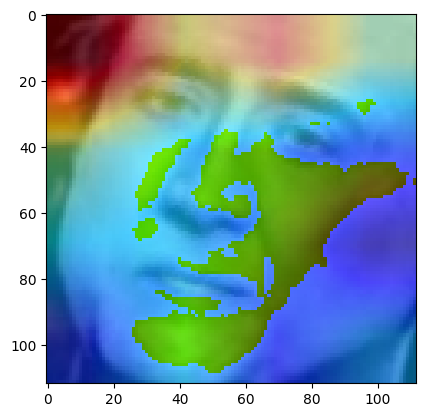

EDITED VIDEO.  Confidence:  99.95155334472656 



In [8]:
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])


video_directory = r"E:\KLTN__Final\code\Video_test"
# video_directory = r"E:\KLTN__Final\code\Video_test\Rawvideo"

all_files = os.listdir(video_directory)
# path_to_videos = [os.path.join(video_directory, f) for f in all_files if f.endswith('.mp4')]

path_to_videos = [r"E:\KLTN__Final\code\Video_test\3_fake.mp4"]

video_dataset = validation_dataset(path_to_videos,sequence_length = 20,transform = train_transforms)
model = Model(2)
path_to_model = 'E:\KLTN__Final\code\Model\model.pt'
model.load_state_dict(torch.load(path_to_model, map_location=torch.device('cpu')))
model.eval()
for i in range(0,len(path_to_videos)):
  print(path_to_videos[i])
  prediction = predict(model,video_dataset[i],'./')
  if prediction[0] == 1 and prediction[1] > 90:
    print("RAW VIDEO. ", "Confidence: ", prediction[1], "\n")
  elif prediction[0] == 0 and prediction[1] > 90:
    print("EDITED VIDEO. ", "Confidence: ", prediction[1], "\n")
  else: 
    print("0 - EDITED VIDEO, 1 - RAW VIDEO \n",prediction[0], " Confidence" , prediction[1], "\n")